# pytorch基础
1. Tensors
2. autograd
3. datasets & dataloaders & transforms
4. training loop


# toxic prediction
6. representation of a molecule
7. molenet dataset
8. training a Neural Network 

In [ ]:
### Tensors



In [1]:
import torch
import numpy as np



np_array_A = np.random.rand(300,20)
np_array_B = np.random.rand(20,300)

torch_array_A = torch.from_numpy(np_array_A).to('cuda')
torch_array_B = torch.from_numpy(np_array_B).to('cuda')
import time

start_time= time.time()
np.matmul(np_array_A,np_array_B)
np_time=time.time()-start_time

print(f"np time {np_time}")


start_time= time.time()
torch.matmul(torch_array_A,torch_array_B)
torch_time=time.time()-start_time

print(f"torch time {torch_time}")

np time 0.005728006362915039
torch time 0.07931995391845703


In [2]:
print(torch_array_A.layout)
print(torch_array_A.device)
print(torch_array_A.dtype)

torch.strided
cuda:0
torch.float64


In [ ]:
# 举例子：one-hot

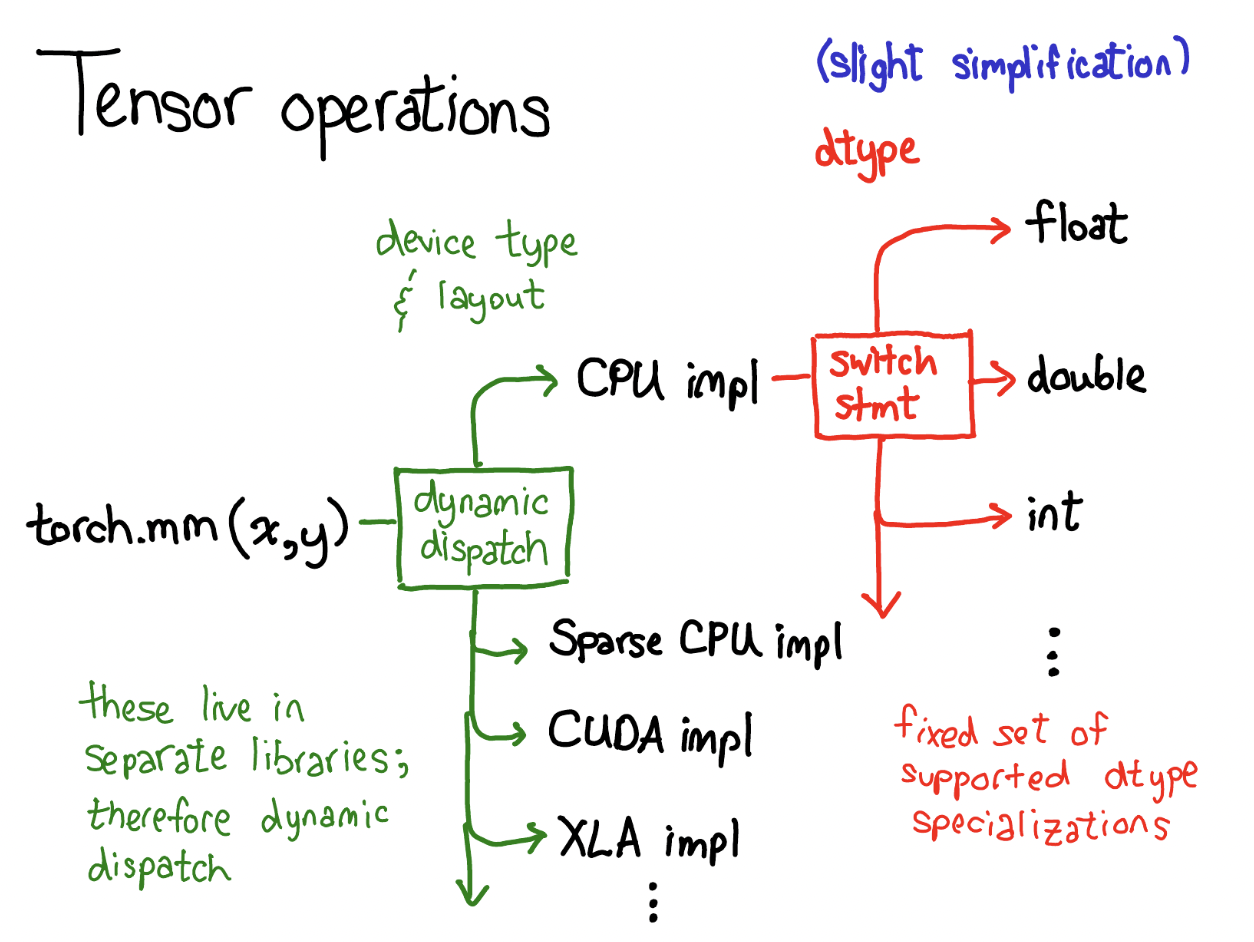

## Autograd

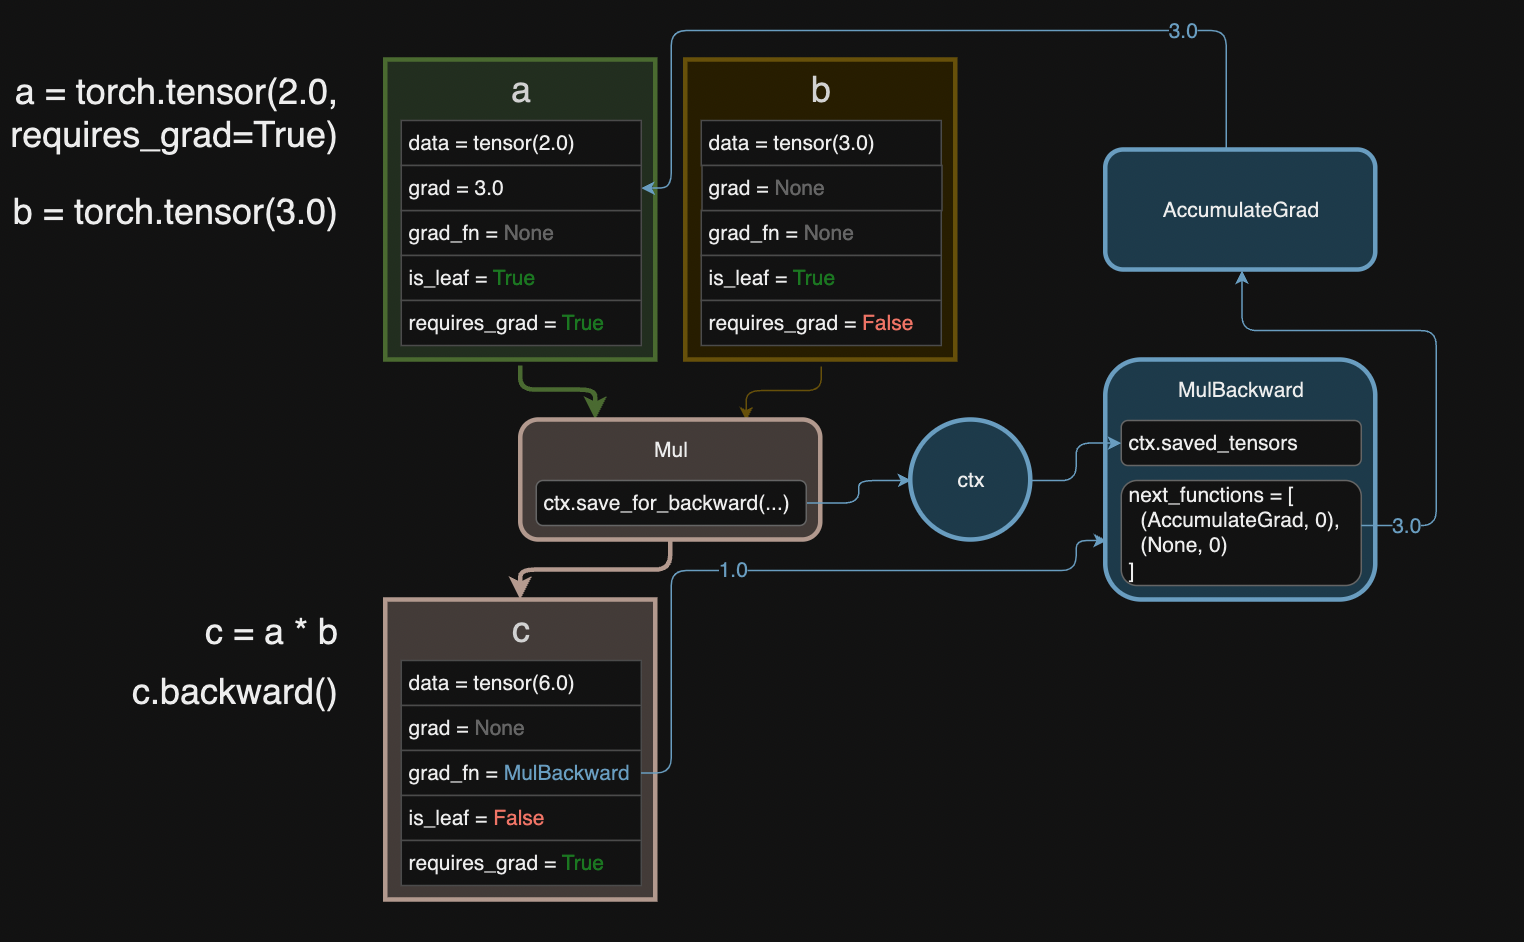

In [3]:
a=torch.tensor(2.0, requires_grad=True)
b=torch.tensor(3.0, requires_grad=False)

c = a * b

c.backward()
print(a.grad)

tensor(3.)


**a more detaled example:**

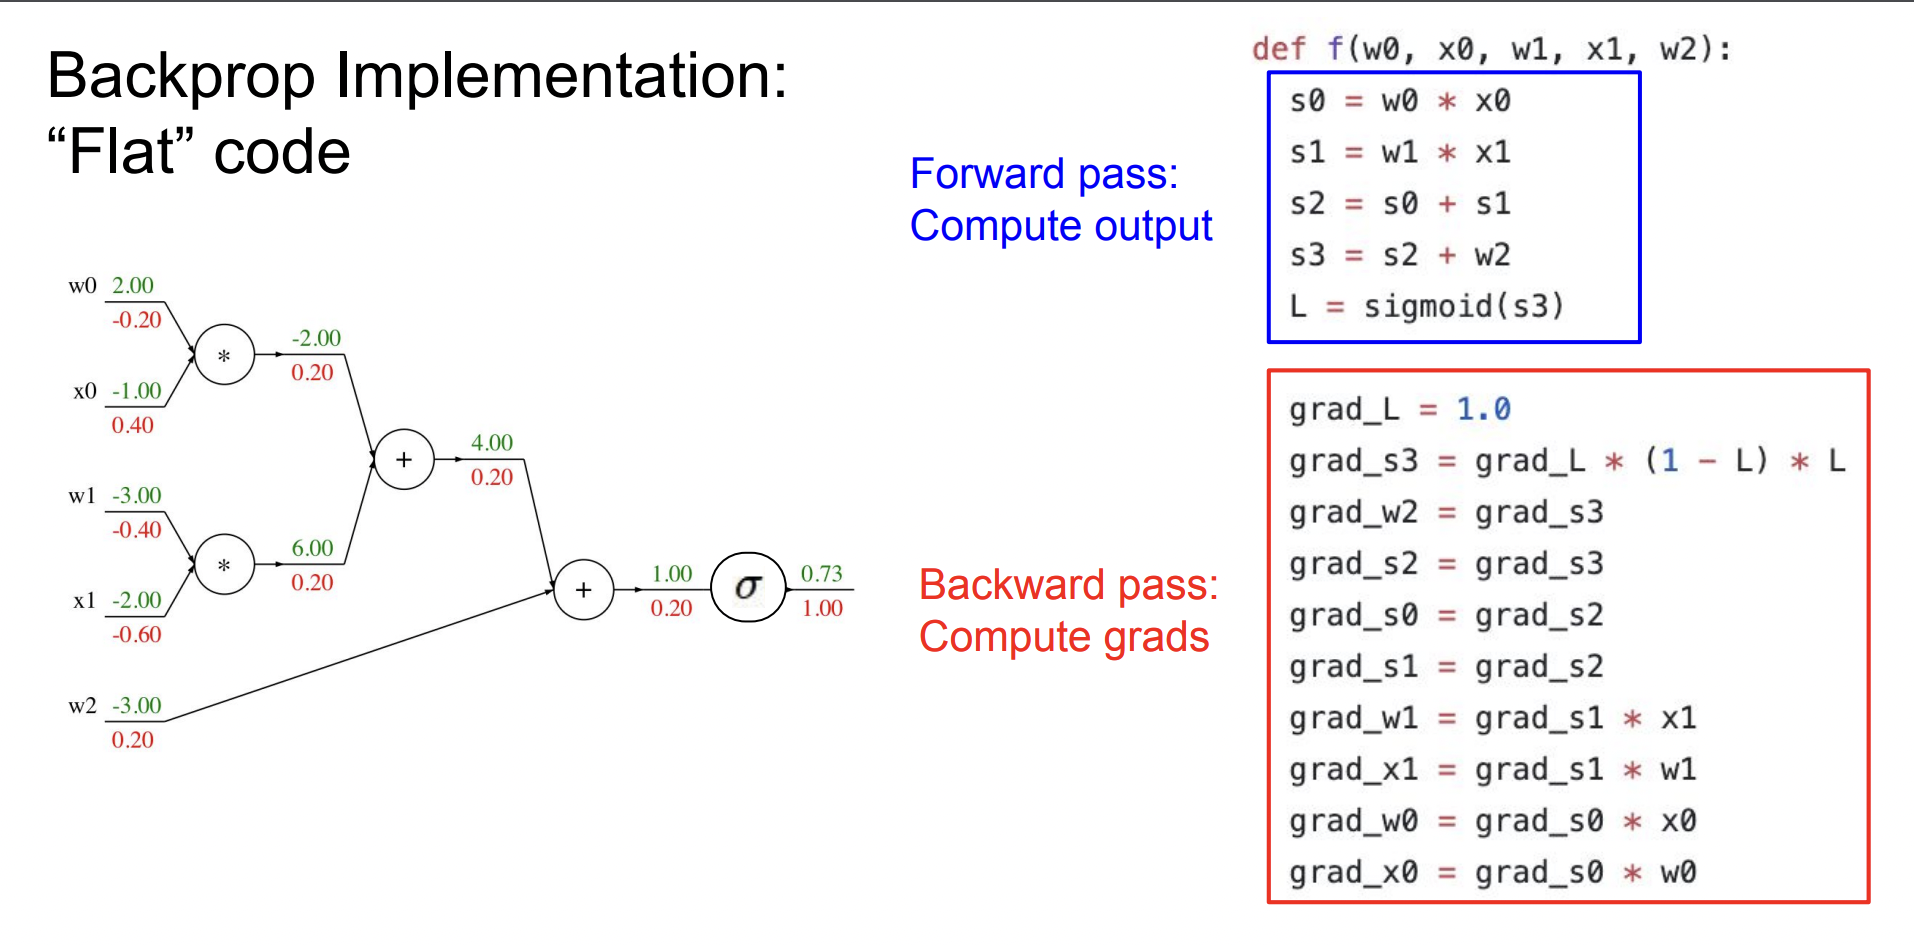

image-source: https://cs231n.stanford.edu/slides/2019/cs231n_2019_lecture04.pdf



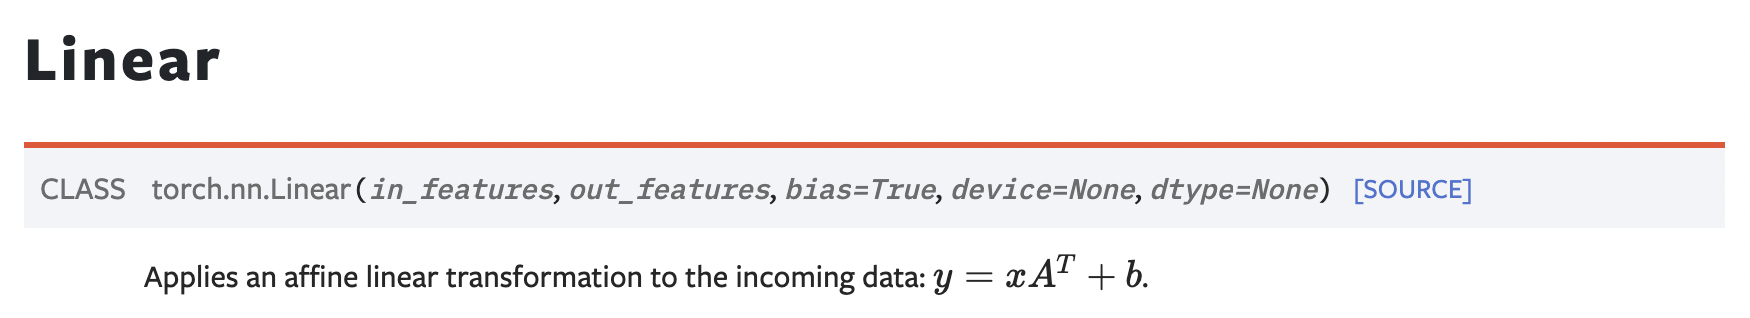

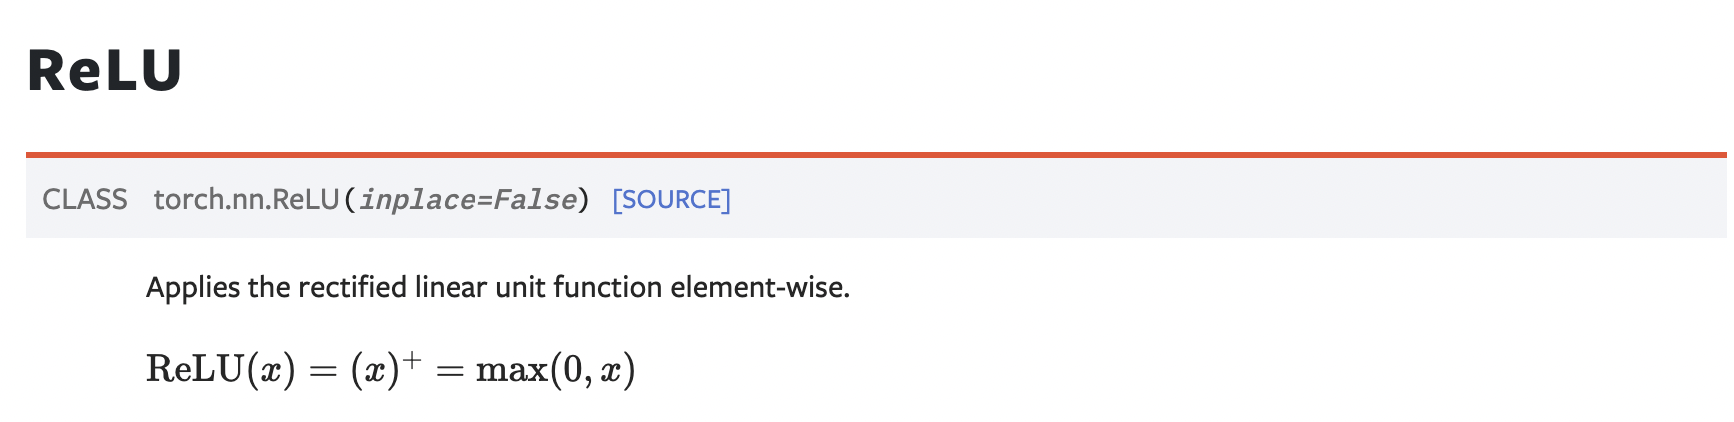

In [4]:

BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(DIM_IN, HIDDEN_SIZE)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(HIDDEN_SIZE, DIM_OUT)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(145.1943, grad_fn=<SumBackward0>)


In [6]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0045, -0.0686, -0.0588,  0.0829, -0.0447, -0.0137,  0.0287,  0.0556,
        -0.0973,  0.0370], grad_fn=<SliceBackward0>)
None
tensor([-0.0045, -0.0686, -0.0588,  0.0829, -0.0447, -0.0137,  0.0287,  0.0556,
        -0.0973,  0.0370], grad_fn=<SliceBackward0>)
tensor([ 0.9261, 11.2027,  4.1557,  3.6313, -1.5908, -3.8506,  0.1853,  2.9925,
        -2.7196, -1.3868])
tensor([-0.0054, -0.0798, -0.0630,  0.0793, -0.0431, -0.0099,  0.0285,  0.0527,
        -0.0946,  0.0384], grad_fn=<SliceBackward0>)
tensor([ 0.9261, 11.2027,  4.1557,  3.6313, -1.5908, -3.8506,  0.1853,  2.9925,
        -2.7196, -1.3868])


datasets & dataloaders & transforms

- dataset: 数据怎么从原有介质被读取到内存中作为一个sample
- transformers: 作为dataloader的参数，对数据进行变换，最常见的例子是cv中的数据增强
- dataloader: 将sample collate(装钉、整理) 成batch，有分布式和pin-memory之类的优化, 还可以接受sampler。


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = []
        
        with open(annotations_file,'r') as f:
            for line in f.readlines():
                data=line.split(' ')
                assert len(data)==2
                self.img_labels.append((data[0],data[1]))
        
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label= self.img_labels[idx]
        
        img_path = os.path.join(self.img_dir, img_path)
        image = read_image(img_path)
        label = int(label)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
ds = CustomImageDataset('data/labels.txt','data')
import matplotlib.pyplot as plt
plt.imshow(ds[0][0].permute(1,2,0))

In [ ]:
from torchvision.transforms import v2
transforms = v2.Compose([v2.RandomVerticalFlip()])
ds = CustomImageDataset('data/labels.txt','data',transform=transforms)
plt.imshow(ds[0][0].permute(1,2,0))

In [ ]:
from torch.utils.data import DataLoader,dataset

train_dataloader = DataLoader(ds, batch_size=2, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))

In [21]:
from torch.utils.data import DataLoader,Dataset

## Training Loop

一般训练一个神经网络需要以下几个步骤：

1）准备数据

2）定义一个**合适**的神经网络

3）objective：大小、结构、model type、regularization etc

4）找一个方法优化参数：weight decay、grad-clip、optimizer etc

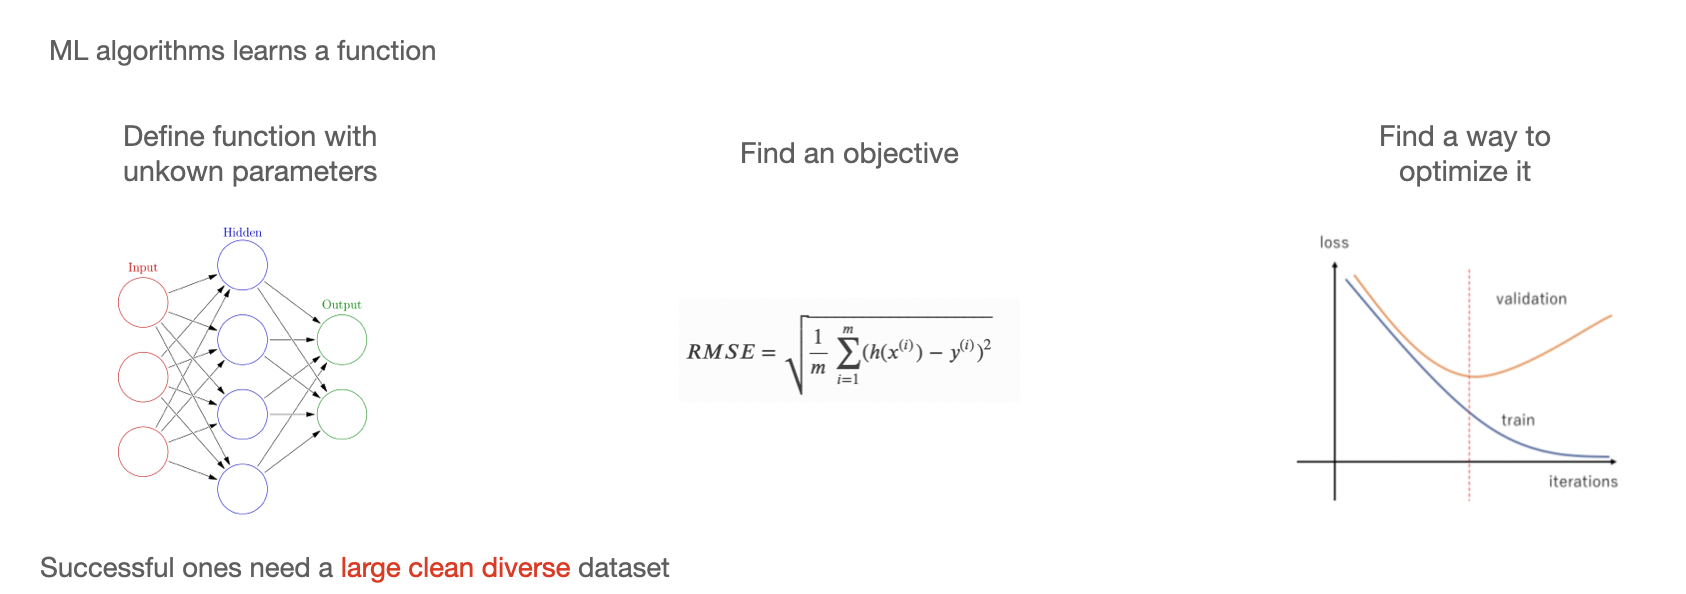

In [7]:
# pseudo code


# 定义网络
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

# 定义loss
loss_fn= nn.CrossEntropyLoss()

# 定义optimizer
optimizer=  torch.optim.SGD(model.parameters(), lr=learning_rate)

# 定义training data、 valid data、 test data
train_dataset = CustomImageDataset('data/train.txt','data',transform=transforms)
train_dataloader = DataLoader(ds, batch_size=2, shuffle=True)
valid_dataset = CustomImageDataset('data/test.txt','data',transform=transforms)
valid_dataloader = DataLoader(ds, batch_size=2, shuffle=False)


# training loop

for i in range(EPOCH):
    
    # train
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # validation
    model.eval()
    for batch, (X, y) in enumerate(test_dataloader):
        # Compute prediction and loss
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
# save
torch.save(model.state_dict(), 'model_weights.pth')




NameError: name 'nn' is not defined

## representation of molecule

- 1D String
- 2D Graph
- 3D Geometry
- 3D mesh
- Chemical Images
- Descriptors and Fingerprints

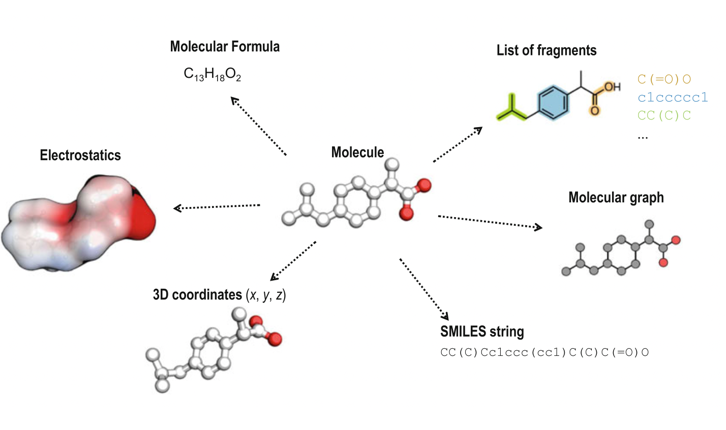

## Tox21

In [13]:
import deepchem
tox21_tasks, tox21_datasets, transforms = deepchem.molnet.load_tox21(save_dir='tox21')

In [14]:
tox21_train_dataset,tox21_valid_dataset, tox21_test_dataset = tox21_datasets

In [15]:
print(tox21_valid_dataset.ids[0],tox21_valid_dataset.X[0].shape, tox21_valid_dataset.y[0], tox21_valid_dataset.w[0])

N#C[C@@H]1CC(F)(F)CN1C(=O)CNC1CC2CCC(C1)N2c1ncccn1 (1024,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1.04502242 1.03632599 1.12502653 1.04541485 1.14607755 1.05621135
 1.02555168 1.17267917 1.03538545 0.         0.         1.05288369]


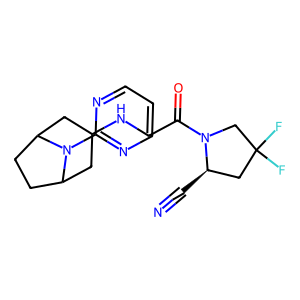

In [16]:
from rdkit.Chem import Draw
from rdkit import Chem
m = Chem.MolFromSmiles(tox21_valid_dataset.ids[0])
img = Draw.MolToImage(m)
img

Morgan-fingerprint

- Number of non-hydrogen immediate neighbors = 3 (atom 3, 5, and 6)
- Valency minus the number of connected hydrogens = 4 (4 - 0)
- Atomic number = 6
- Atomic mass = 12
- Atomic charge = 0
- Number of attached hydrogens = 0
- Is it a part of a ring = 0 (no)

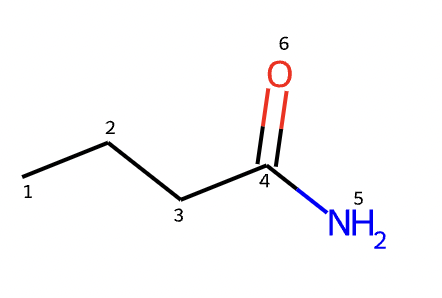

对每个atom进行计算->迭代(根据radius)->去重->映射到1024的vector

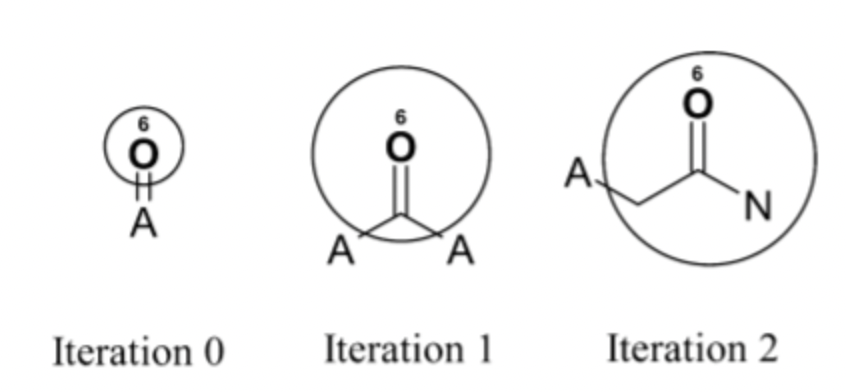


source：
https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html

In [ ]:
tox21_train_dataset,tox21_valid_dataset, tox21_test_dataset

In [18]:
# 药物数据的复杂性，weight为0代表没有assay的结果
import numpy as np

curated_y = np.sum((tox21_train_dataset.y* tox21_train_dataset.w),axis=-1).squeeze()
#curated_y = np.sum((train_dataset.y* train_dataset.w+ (train_dataset.w==0)),axis=-1).squeeze()
print(np.count_nonzero(curated_y))
print(np.count_nonzero(curated_y == 0))

2191
4073


In [ ]:
tox21_train_dataset

In [ ]:
train_dataset[4]

In [20]:
from torch.data_utils import Dataset

ModuleNotFoundError: No module named 'torch.data_utils'

In [22]:
class ToxDataset(Dataset):
    def __init__(self, tox_dataset, transform=None, target_transform=None):
        
        self.labels = (np.sum((tox_dataset.y* tox_dataset.w),axis=-1)>0).astype(np.int64)
        self.X = tox_dataset.X.astype(np.float32)
        self.tox_dataset = tox_dataset
       

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

train_dataset=ToxDataset(tox21_train_dataset)
valid_dataset=ToxDataset(tox21_valid_dataset)
test_dataset=ToxDataset(tox21_test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [24]:
len(train_dataset)

6264

In [ ]:
pred.argmax(1)

In [25]:
import torch
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
 
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight) 

model.apply(weights_init)

model=NeuralNetwork()


model=model.to('cuda:0')
loss_fn= nn.CrossEntropyLoss()

optimizer= torch.optim.SGD(model.parameters(), lr=0.05)


for i in range(50):
    
    # train
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        X=X.to('cuda:0')
        y=y.to('cuda:0')
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 50==0:
        
            print(f'epoch {i}: step {batch}: loss {loss.item()}')
   
    # validation
    model.eval()
    correct=0
    for batch, (X, y) in enumerate(valid_dataloader):
        # Compute prediction and loss
        X=X.to('cuda:0')
        y=y.to('cuda:0')
        pred = model(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    print(f'epoch {i}: acc {correct/len(valid_dataset)}')

correct=0
for batch, (X, y) in enumerate(test_dataloader):
    # Compute prediction and loss
    X=X.to('cuda:0')
    y=y.to('cuda:0')
    pred = model(X)
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()

print(f'test : acc {correct/len(test_dataset)}')


epoch 0: step 0: loss 0.6941420435905457
epoch 0: step 50: loss 0.7046558260917664
epoch 0: acc 0.5670498084291188
epoch 1: step 0: loss 0.6500116586685181
epoch 1: step 50: loss 0.699124813079834
epoch 1: acc 0.5670498084291188
epoch 2: step 0: loss 0.6713613867759705
epoch 2: step 50: loss 0.546109676361084
epoch 2: acc 0.5683269476372924
epoch 3: step 0: loss 0.5554877519607544
epoch 3: step 50: loss 0.5653147101402283
epoch 3: acc 0.6168582375478927
epoch 4: step 0: loss 0.6300604343414307
epoch 4: step 50: loss 0.6105319261550903
epoch 4: acc 0.6206896551724138
epoch 5: step 0: loss 0.4750989079475403
epoch 5: step 50: loss 0.5090388655662537
epoch 5: acc 0.6181353767560664
epoch 6: step 0: loss 0.43545567989349365
epoch 6: step 50: loss 0.5297780632972717
epoch 6: acc 0.632183908045977
epoch 7: step 0: loss 0.5739580392837524
epoch 7: step 50: loss 0.5342593193054199
epoch 7: acc 0.6424010217113666
epoch 8: step 0: loss 0.5318241715431213
epoch 8: step 50: loss 0.4070820808410644

In [ ]:
loss.device

In [ ]:
思考：
能想到什么方法把该模型变的更好？多任务-平衡-dropout？


more to it：

数据的限制：
1.内插与外推：目前的深度学习模型是内插能力强，所以需要大量的数据（data-hungry）
2.从第一性原理来讲，到底有用什么去表示？
3.足量的数据不现实，深度学习的起点是imagenet


模型的限制：
1. 3D等变性与模型表征能力的矛盾
2. foundation model学习的表征

下节课：
pytorch分布式训练（data parallel、集合通信）
生成式模型原理
先导化合物优化
